In [2]:
import cv2,mmcv
from PIL import Image, ImageDraw
from keras_facenet import FaceNet
import numpy as np
import time
from numpy import dot
from numpy.linalg import norm

from PIL import Image,ImageDraw
import os
np.seterr(divide='ignore', invalid='ignore')


c:\Users\Raum\Desktop\Video_blur\new_e\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [114]:
def cosine_similarity(a, b):
    a = np.array(a,dtype=np.float32)
    b = np.array(b,dtype=np.float32)
    value_AB = dot(a, b) / (norm(a) * norm(b))
    return 0.0 if value_AB != value_AB else value_AB

def clear_Faces_lock(folder):
  if os.listdir(folder+'/') !=[]:
    for i in os.listdir(folder+'/'):
        folder_folder = os.path.join(folder+'/',i)
        for i in os.listdir(folder_folder+'/'):
            os.remove(os.path.join(folder_folder+'/',i))
        os.rmdir(folder_folder)

In [5]:
''' cosine_similarity frame '''
# video = mmcv.VideoReader(r"C:\Users\Raum\Desktop\jec\code\dataface\animal.mp4")
video = mmcv.VideoReader(r"C:\Users\Raum\Desktop\jec\code\dataface\minutes.mp4")
print('Frames: ',len(video))
masker = 1
arr = np.zeros(len(video))
walk1 =0
walk2 =1
for i in range(len(video)-1):
    frame_1 = cv2.resize(cv2.cvtColor(video[walk1],cv2.COLOR_BGR2RGB),(224,224)).reshape(-1)
    frame_2 = cv2.resize(cv2.cvtColor(video[walk2],cv2.COLOR_BGR2RGB),(224,224)).reshape(-1)
    if cosine_similarity(frame_1,frame_2) ==0.0:
        arr[walk1] = -1
        arr[walk2] = -1
    if cosine_similarity(frame_1,frame_2) >= 0.80:
        arr[walk1] = masker
        arr[walk2] = masker
    else:
        arr[walk1] = masker
        masker +=1
        arr[walk2] = masker
    walk1 +=1
    walk2 +=1


Frames:  9745


In [ ]:
# for j,i in enumerate(arr):
#     print(j,i)


In [105]:
def check_sence(i,j):
    frame_1 = cv2.resize(cv2.cvtColor(video[i],cv2.COLOR_BGR2RGB),(224,224)).reshape(-1)
    frame_2 = cv2.resize(cv2.cvtColor(video[j],cv2.COLOR_BGR2RGB),(224,224)).reshape(-1)
    print(cosine_similarity(frame_1,frame_2))

def check_face(ifm,jfm,have=None):
    embedder = FaceNet()
    em1=0
    em2=0
    if have:
        em1 = ifm
        em2 = jfm
    else:
        img1 = cv2.cvtColor(cv2.imread(ifm),cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(cv2.imread(jfm),cv2.COLOR_BGR2RGB)
        img1 = np.expand_dims(img1,axis=0)
        img2 = np.expand_dims(img2,axis=0)
        em1 = embedder.embeddings(img1)
        em2 = embedder.embeddings(img2)
    print(cosine_similarity(em1[0],em2[0]))
check_sence(202,203)

0.822337


In [7]:
# test .

# เหตุผลว่าทำไม ไม่ใช้ 1 รูปแบบตัดหน้าแล้วนำมาหาในภาพอื่นด้วย
# print(cosine_similarity(em1[0],em2[0]))
# del embedder

0.84936696


In [6]:
values, index_frames,index_count = np.unique(arr,return_index=True,return_counts=True)

In [7]:
values.min(),values.max()

(1.0, 24.0)

In [8]:
Frame_similarity = index_count//2 ;'''get middle frame'''
Frame_last = (index_count+index_frames) ;'''get last frame'''

'get last frame'

In [9]:
# ai predict frame
# import torch
# print(torch.cuda.is_available())
import yolov5
model =  yolov5.load(r"C:\Users\Raum\Desktop\crowdhuman_yolov5m.pt").to('cuda')

YOLOv5  2023-11-28 Python-3.9.0 torch-1.9.0+cu111 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)

Fusing layers... 
Model summary: 391 layers, 21060447 parameters, 0 gradients
Adding AutoShape... 


In [10]:
'''
    original Prediction AI Frame
    หาว่าเฟรมใดบ้างที่มีใบหน้าอยู่ และ จะเก็บใบหน้าที่มีเพื่อให้ผู้ใช้เลือก
                                                        '''
faces = []
where_start_frame = []
where_mid_frame = []
where_end_frame  = []
start = time.time()
for i in range(len(Frame_similarity)):
    midframe = index_frames[i]+Frame_similarity[i] ;'''เอาค่ากลางที่ได้บวกตำแหน่งปัจจุบันเพื่อหาตำแน่งที่แท้จริง'''
    xxx = model(cv2.cvtColor(video[midframe],cv2.COLOR_BGR2RGB))
    predictions = xxx.pred[0]
    boxes = predictions[:, :4]
    categories = predictions[:, 5]
    Ar = np.where(categories.to('cpu').numpy()==1)[0]
    if Ar.shape[0] !=0:
      faces.append(boxes[Ar].to('cpu').numpy())
      where_start_frame.append(index_frames[i])
      where_mid_frame.append(midframe)
      where_end_frame.append(Frame_last[i])
      continue
end = time.time()
print(end-start) 

7.724019527435303


In [12]:
'''
    crop for selected face by cilent and find value
    ตัดเอาเฉพาะใบหน้าที่พบลงในแต่ละโฟลเดอร์ โดยภายในก็จะหน้าทั้งหมดอยู่
    เพื่อให้ผู้ใช้เลือก
                                                             '''

folder = "Faces-lock"
embedding_faces = {}
embedder = FaceNet()
# clear_Faces_lock(folder)
for i,number in enumerate(where_mid_frame):
  # print(number)
  new_folder = folder+"/Faces_on_frame_{}".format(str(number))
  try:
      os.makedirs(new_folder)
  except:
      # print('folder already exists')
        pass
  EMBED = []
  for N,(x1,y1,x2,y2) in enumerate(faces[i]):
        face = cv2.cvtColor(video[number][int(y1):int(y2),int(x1):int(x2)],cv2.COLOR_BGR2RGB)
        image_face = Image.fromarray(face)
        image_face = image_face.resize((224,224))

        faces_crops = np.array(image_face).reshape(-1,224,224,3)
        EMBED.append(embedder.embeddings(faces_crops))

        path = new_folder+'/Face_{}.png'.format(N+1) # path for collect images
        image_face.save(path)
  embedding_faces[f'{str(number)}'] = EMBED
print('There are faces in Frames:',len(embedding_faces))

There are faces in Frames: 23


In [ ]:
# video.cvt2frames(r'C:\Users\Raum\Desktop\Video_blur\test')

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 9745/9745, 26.8 task/s, elapsed: 364s, ETA:     0s


In [13]:
for i in range(len(where_mid_frame)):
    print(where_start_frame[i],where_mid_frame[i],where_end_frame[i])

0 174 349
349 528 708
708 789 871
871 970 1070
1070 1228 1386
1386 1632 1879
1879 2010 2142
2142 2217 2293
2293 2444 2596
2596 2658 2720
2720 3365 4010
4010 4224 4438
4438 4582 4727
4727 5158 5589
5589 5894 6199
6199 6224 6250
6250 6359 6468
6468 6548 6628
6628 6804 6980
6980 7812 8645
8645 8849 9054
9054 9135 9216
9216 9446 9677


In [184]:
''' blur Process each feame'''
face_lock = {NAME:[] for NAME in embedding_faces.keys()}
# face_lock['174'].append(3)
# face_lock['174'].append(4)
# face_lock['174'].append(5)
face_lock,len(face_lock)

({'174': [],
  '528': [],
  '789': [],
  '970': [],
  '1228': [],
  '1632': [],
  '2010': [],
  '2217': [],
  '2444': [],
  '2658': [],
  '3365': [],
  '4224': [],
  '4582': [],
  '5158': [],
  '5894': [],
  '6224': [],
  '6359': [],
  '6548': [],
  '6804': [],
  '7812': [],
  '8849': [],
  '9135': [],
  '9446': []},
 23)

In [193]:
video = mmcv.VideoReader(r"C:\Users\Raum\Desktop\jec\code\dataface\minutes.mp4")

IN_FRAME = 9135  
DATA_FACE_ON_FRAME = '9135'
image = video[IN_FRAME]

Y = model(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
predictions = Y.pred[0]
boxes = predictions[:, :4]
categories = predictions[:, 5]
Ar = np.where(categories.to('cpu').numpy()==1)[0]
# print(boxes[Ar])
embedding_one_frame = []
cnt = 0
boxes = boxes[Ar].to('cpu').numpy()
for x1,y1,x2,y2  in boxes:

    face = video[IN_FRAME][int(y1):int(y2),int(x1):int(x2)]
    image_face = Image.fromarray(face)
    image_face = image_face.resize((224,224))

    faces_crops = np.array(image_face).reshape(-1,224,224,3)
    
    embedding_one_frame.append(embedder.embeddings(faces_crops))
    cv2.imwrite(f'{int(cnt)}.png',np.array(image_face))
    cnt +=1

    


Detection_check = np.zeros((len(embedding_one_frame)))
if face_lock : 
    for index_face in face_lock[DATA_FACE_ON_FRAME]:

        for j in range(len(embedding_one_frame)):
            similar = cosine_similarity(embedding_one_frame[j][0],embedding_faces[DATA_FACE_ON_FRAME][index_face][0])

            if similar>=0.70 and Detection_check[j] == 0 :
                Detection_check[j] = 1
                # break

print(Detection_check)

# Filter_oFF = True
Filter_oFF = False

IN_BY_FRAME = IN_FRAME+2

for index_box,DE_CRECK in enumerate(Detection_check):
    x1, y1, x2, y2 = int(boxes[index_box][0]),int(boxes[index_box][1]),int(boxes[index_box][2]),int(boxes[index_box][3])
    if DE_CRECK !=1:
        # print('ok',DE_CRECK)
        if Filter_oFF:
            censor_region = (x1,y1,x2,y2)
            censored_area = image[censor_region[1]:censor_region[3], censor_region[0]:censor_region[2]]
            censored_width, censored_height = censored_area.shape[1], censored_area.shape[0]
            pixel_size = 8
            censored_area = cv2.resize(censored_area, (pixel_size,pixel_size))
            censored_area = cv2.resize(censored_area, (censored_width, censored_height), interpolation=cv2.INTER_NEAREST)
            video[IN_BY_FRAME][censor_region[1]:censor_region[3], censor_region[0]:censor_region[2]] = censored_area
            video[IN_BY_FRAME][:,:] = video[IN_BY_FRAME]
        else:
            fitter_ = Image.open(r"C:\Users\Raum\Desktop\jec\code\dataface\dogmeme.png").convert("RGBA")
            x = int(x2-x1) 
            y = int(y2-y1) 
            fitter_ = fitter_.resize((x,y))
            fill_image = Image.fromarray(cv2.cvtColor(video[IN_BY_FRAME],cv2.COLOR_BGR2RGB))
            fill_image.paste(fitter_,(x1,y1),fitter_)
            video[IN_BY_FRAME][:,:,::-1] = fill_image

    '''check only'''
    # img = Image.fromarray(video[IN_BY_FRAME][:,:])
    # draw = ImageDraw.Draw(img)
    # draw.rectangle([(x1,y1),(x2,y2)],outline=(21,255,0),width=5)
    # video[IN_BY_FRAME][:,:,::-1] = np.array(img)



[          0           0           0]


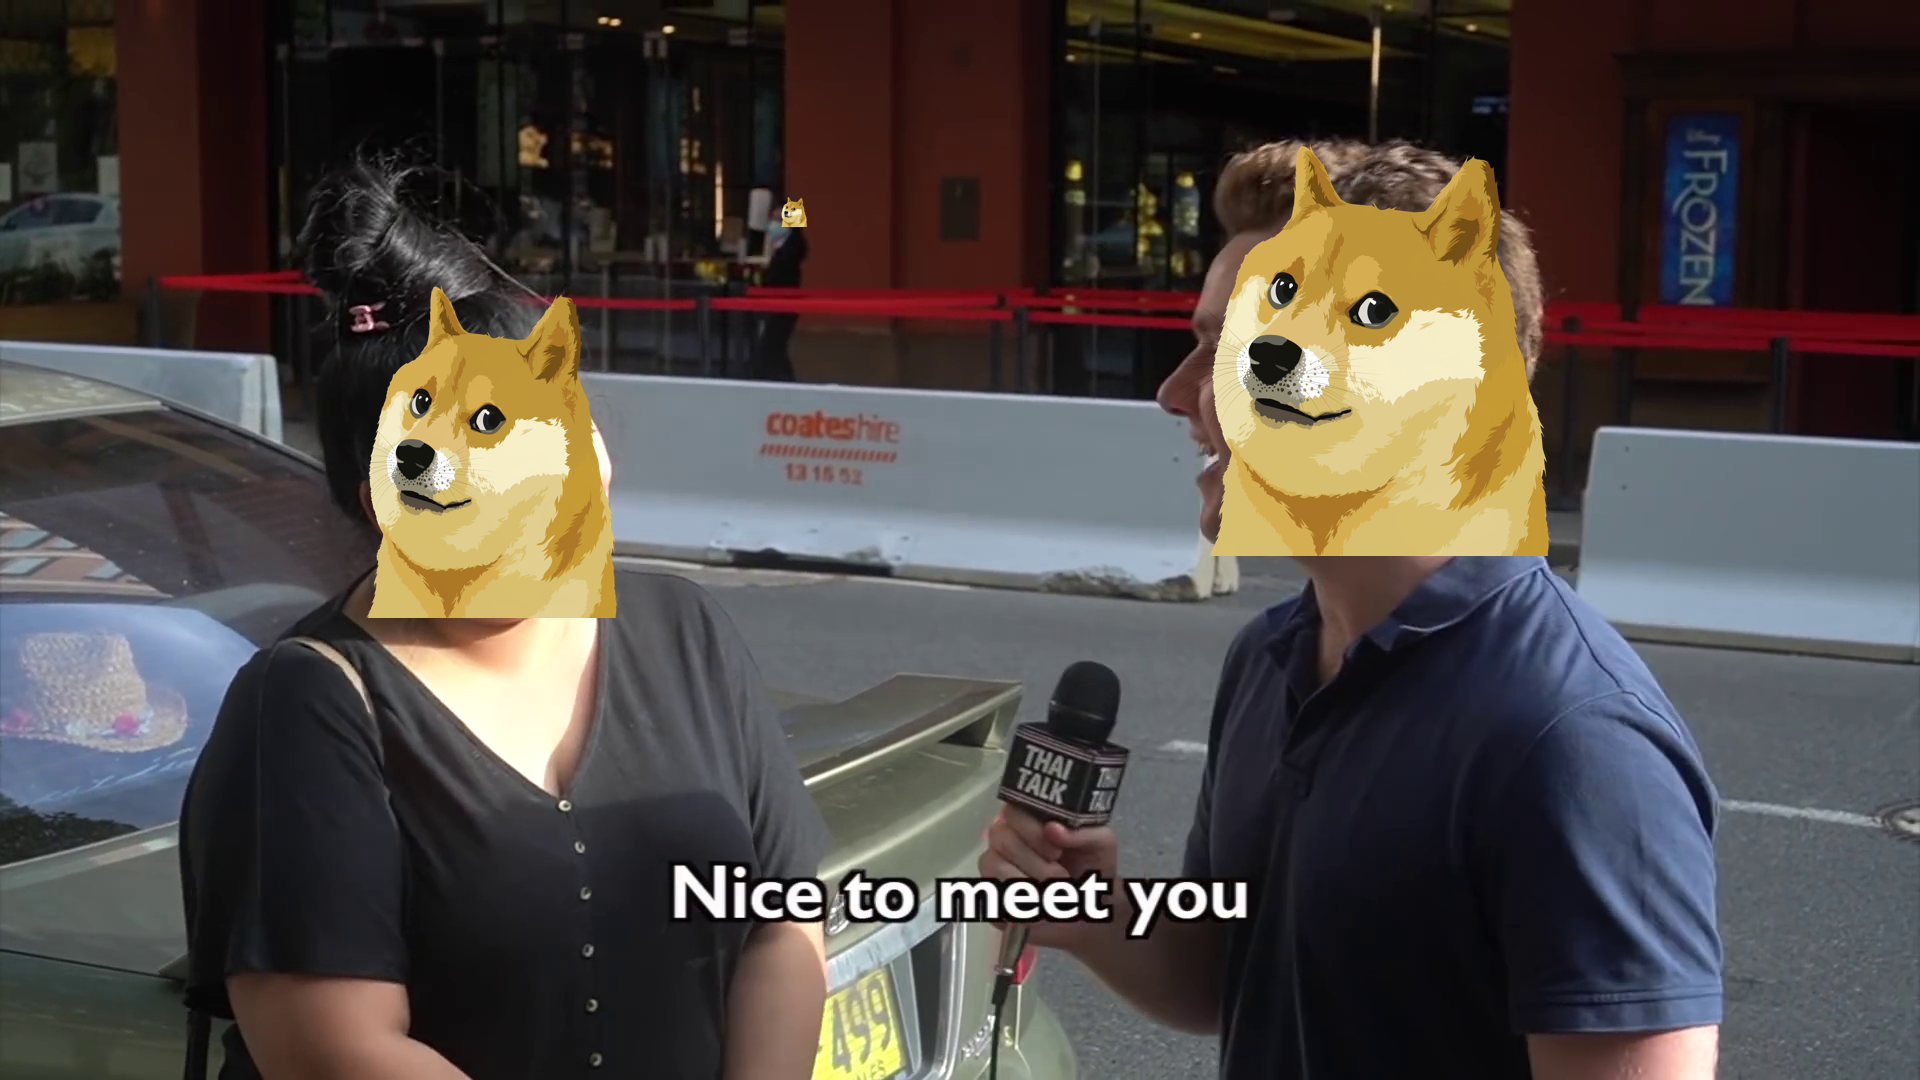

In [194]:
Image.fromarray(cv2.cvtColor(video[IN_BY_FRAME],cv2.COLOR_BGR2RGB))


In [20]:

for i in range(len(embedding_faces)):
    cnt = 0
    for j in range(where_start_frame[i],where_end_frame[i]):

        if cnt ==0:
            print("index : ",j)
            Y = model(cv2.cvtColor(video[j],cv2.COLOR_BGR2RGB))
            predictions = Y.pred[0]
            boxes = predictions[:, :4]
            categories = predictions[:, 5]
            Ar = np.where(categories.to('cpu').numpy()==1)[0]
        if cnt ==5:
            print("new")
            cnt =0
        
        if Ar.shape[0] !=0:
            print(boxes[Ar].to('cpu').numpy())
        cnt+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
''' write frames to video'''

dim = video[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')
Video_Writer = cv2.VideoWriter('video_New.mp4', fourcc, 25.0, dim)
for frame in video:
    Video_Writer.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))

Video_Writer.release()